In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

In [84]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/kaggle/input/oil-spill/oil-spill/train/images'
LABELS_PATH = '/kaggle/input/oil-spill/oil-spill/train/labels'

IMG_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/images'
LABELS_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/labels'

In [85]:
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

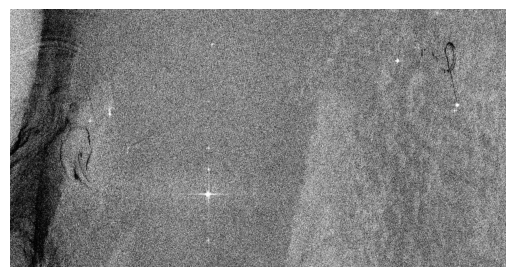

Randomly selected image: img_0006.jpg


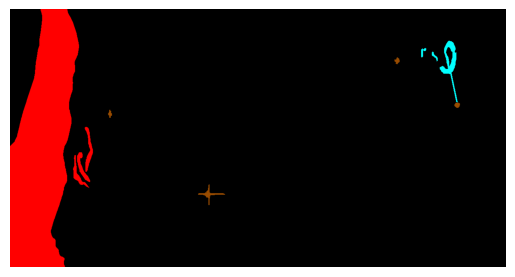

Randomly selected mask: img_0006.png


In [86]:
# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [87]:
COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [88]:
train_images = []
train_masks = []

test_images = []
test_masks = []

In [89]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:31<00:00, 32.26it/s]


In [90]:
train_masks.shape

(1002, 256, 256, 1)

In [91]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


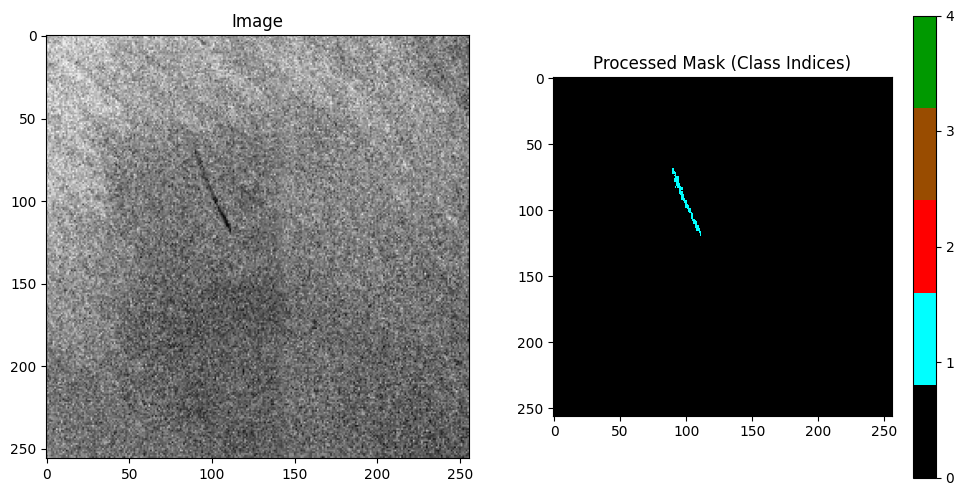

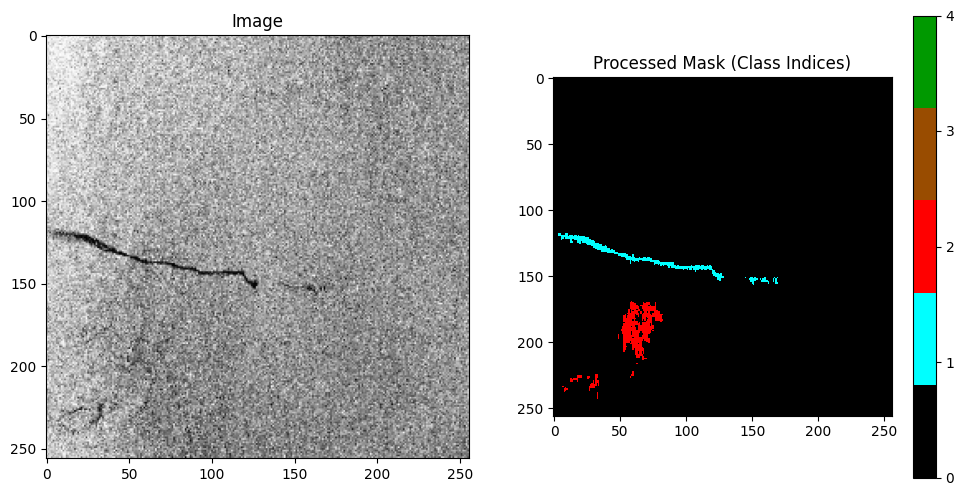

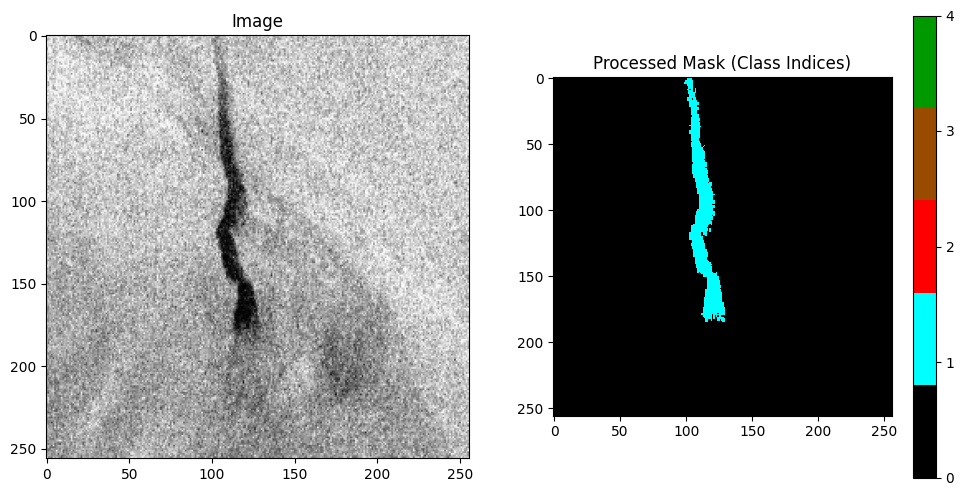

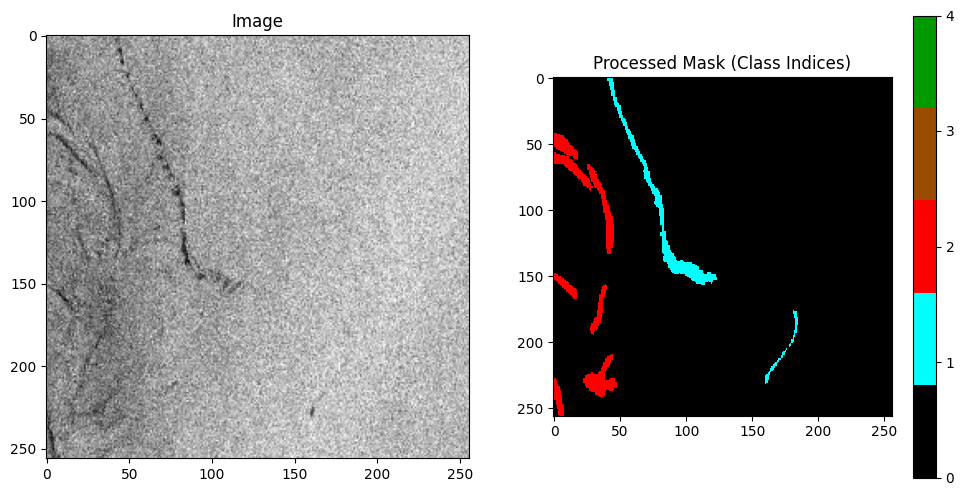

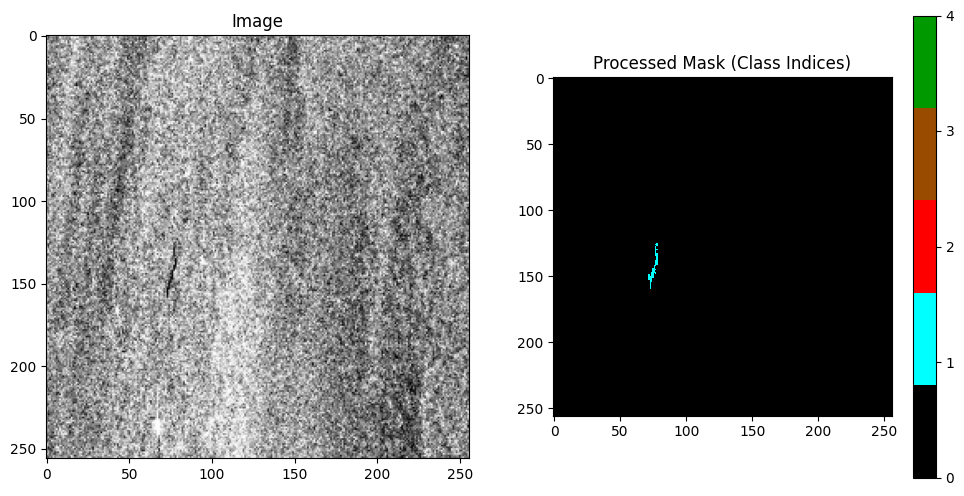

In [92]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

In [93]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:03<00:00, 31.84it/s]


In [94]:
test_masks.shape

(110, 256, 256, 1)

In [95]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


In [96]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)

In [97]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [98]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [99]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


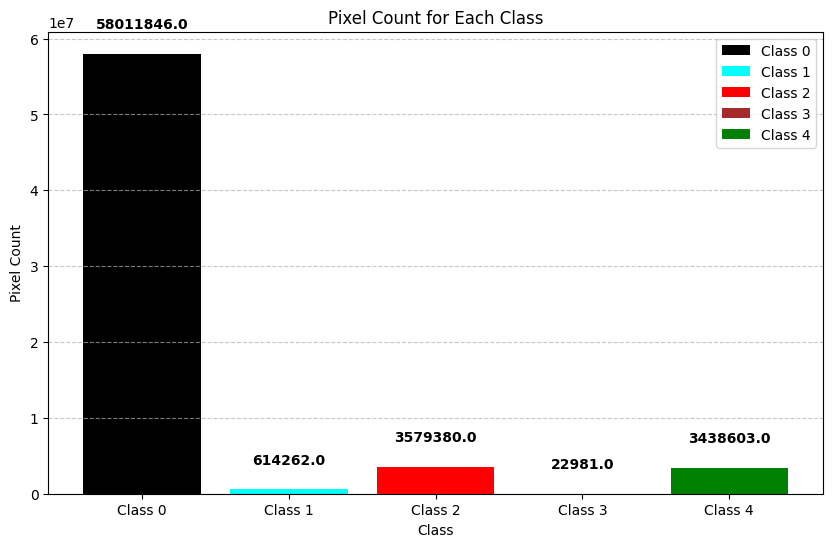

In [100]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [101]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [102]:
def UNet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

In [103]:
unet_model = UNet(input_shape, IMG_CLASSES)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,173 (7.40 MB)

 Trainable params: 1,941,173 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
tf.keras.backend.clear_session()

unet_model.compile(optimizer="adam", loss='categorical_crossentropy')

In [106]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # You can also use 'val_accuracy' or another metric
                               patience=10,          # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best weights after stopping
                               verbose=1)

# Fit the model with EarlyStopping
unet_history = unet_model.fit(train_images, train_masks,
                              epochs=100,
                              batch_size=16,
                              validation_split=0.1,
                              verbose=1,
                              callbacks=[early_stopping])


Epoch 1/100


I0000 00:00:1745702845.022430     152 service.cc:148] XLA service 0x79f4940105b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745702845.025840     152 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745702845.025895     152 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745702846.174056     152 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/57 ━━━━━━━━━━━━━━━━━━━━ 29:47 32s/step - loss: 1.8841

I0000 00:00:1745702866.533073     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 534ms/step - loss: 1.0111 - val_loss: 0.4458
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.4805 - val_loss: 0.4047
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.4194 - val_loss: 0.4560
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - loss: 0.3921 - val_loss: 0.4721
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.4068 - val_loss: 0.2824
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.3380 - val_loss: 0.2693
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.3112 - val_loss: 0.2893
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.3315 - val_loss: 0.2415
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.3200 - val_loss: 0.2555
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.2873 - val_loss: 0.2294
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.2644 - val_loss: 0.2362
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/ste

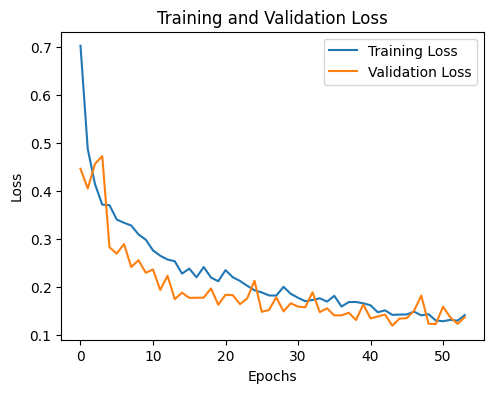

In [112]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


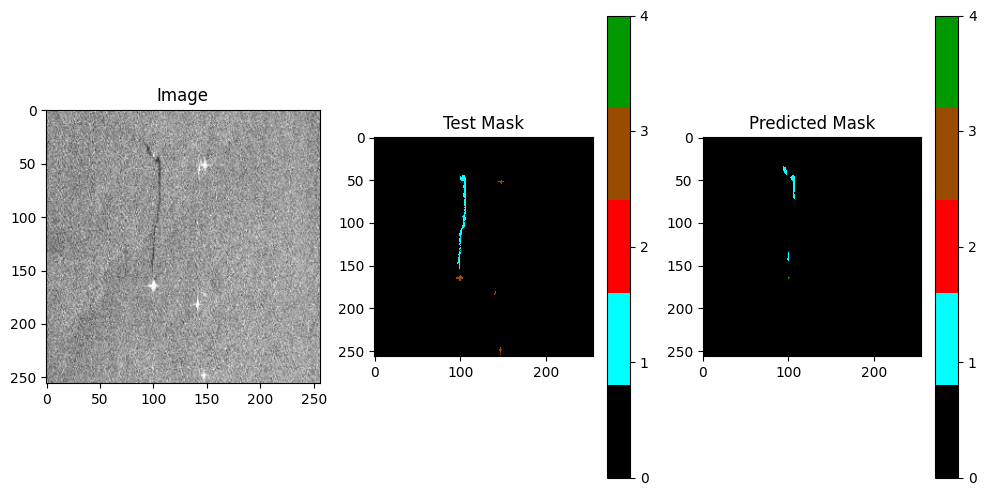

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


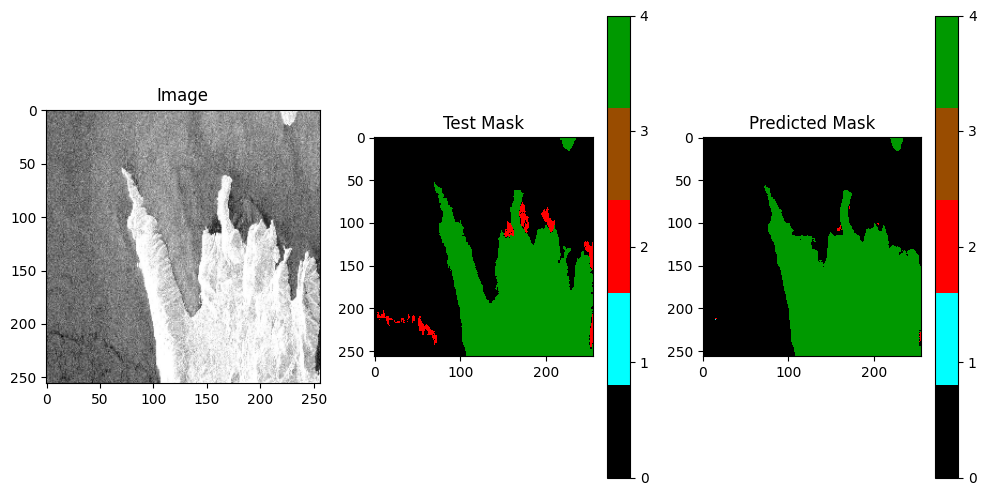

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


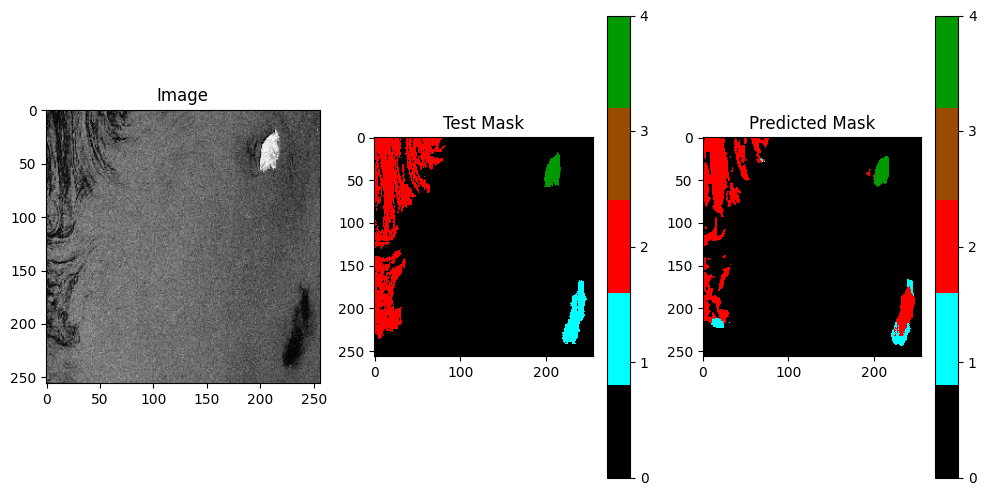

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


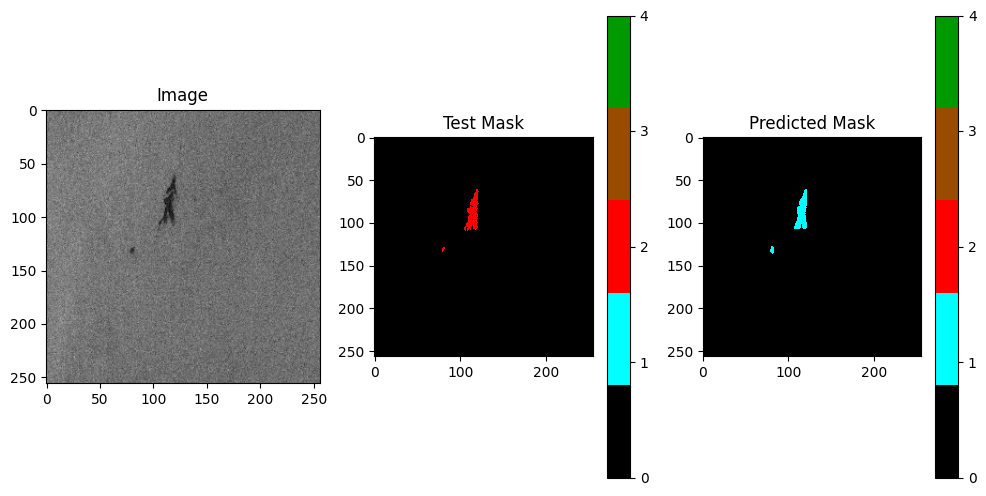

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


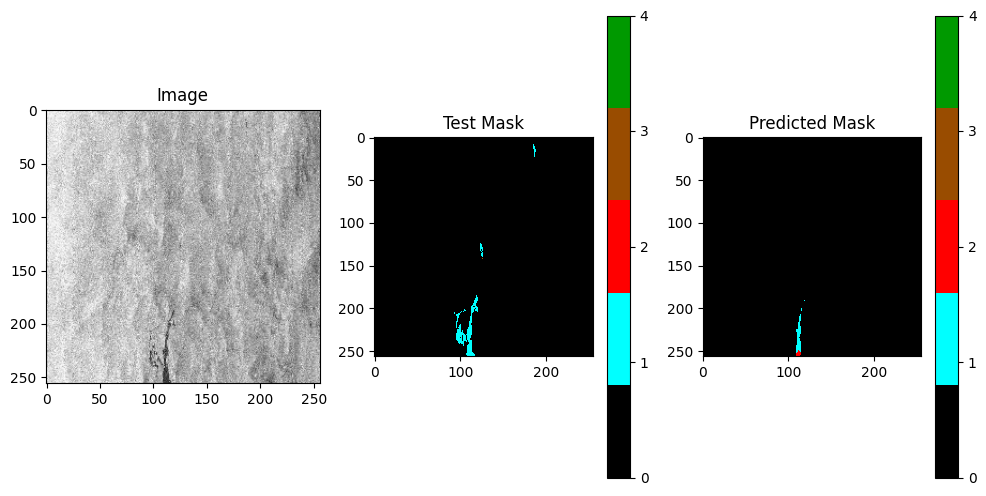

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


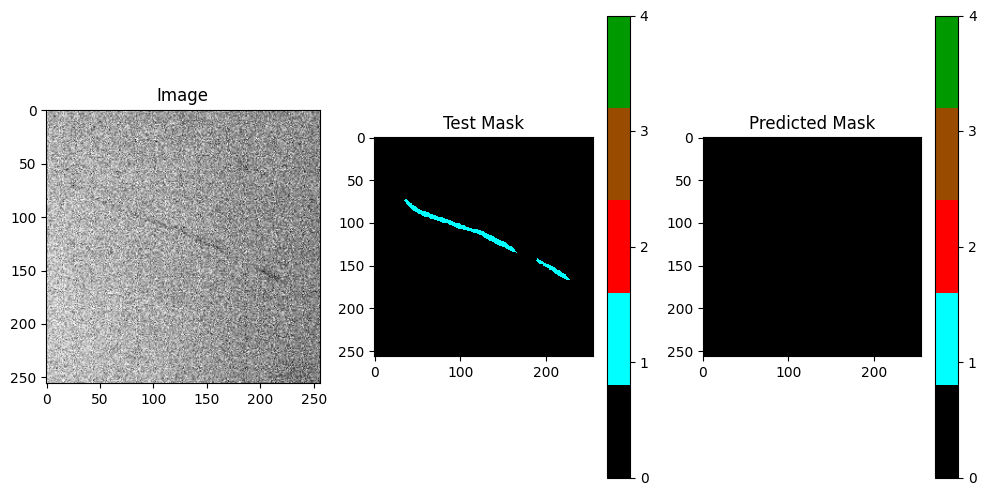

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


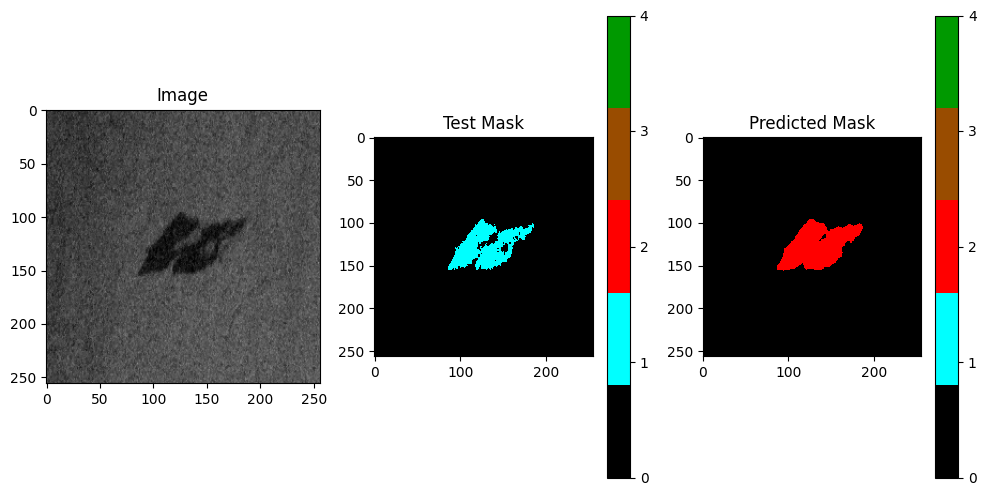

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


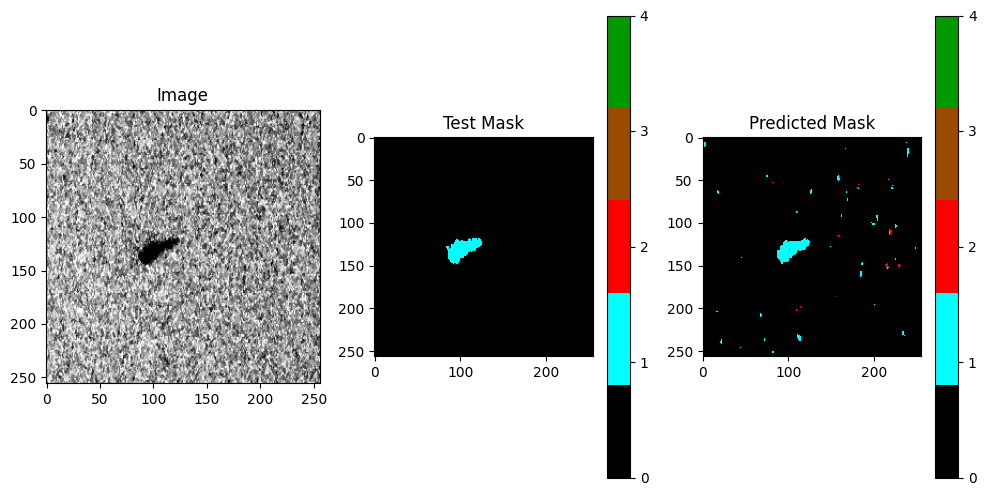

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


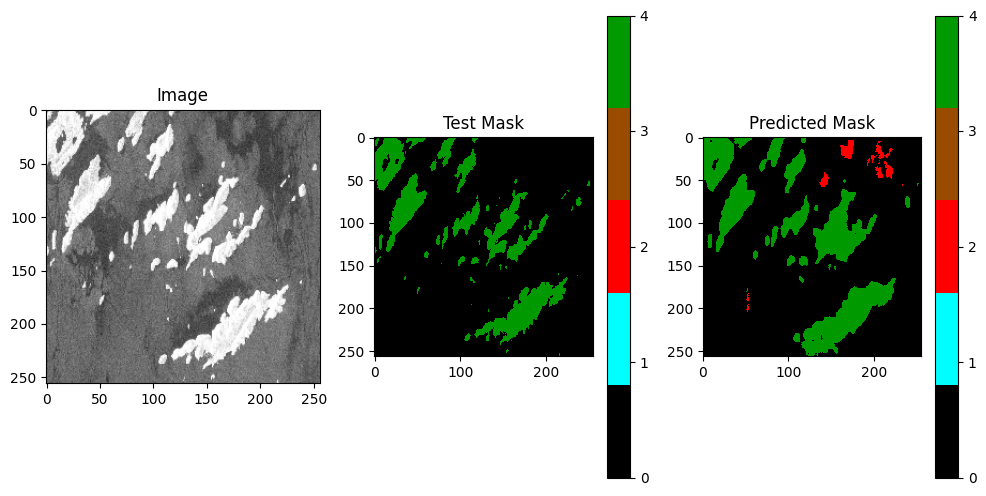

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


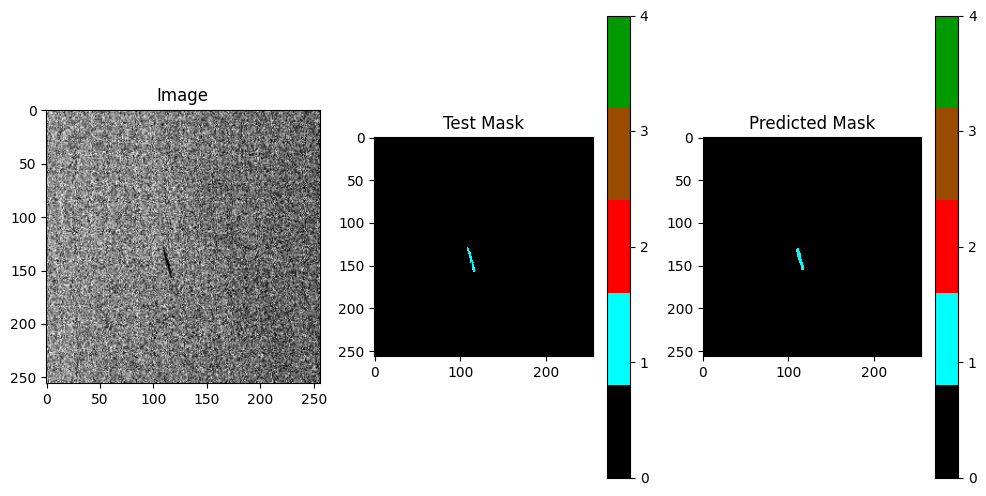

In [113]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    
    # Test Image 
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = unet_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    
    plt.show()


test_masks shape: (110, 256, 256, 1)
prediction_unet shape: (1, 256, 256, 5)
Flattened shapes - True: (65536,), Pred: (65536,)


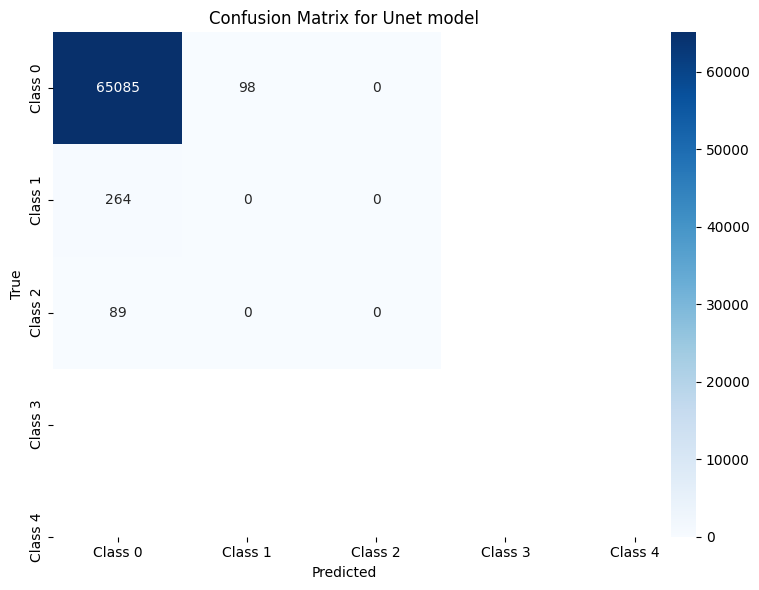

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check shapes
print(f"test_masks shape: {test_masks.shape}")
print(f"prediction_unet shape: {prediction_unet.shape}")

# If prediction_unet has fewer samples than test_masks, slice test_masks
if test_masks.shape[0] != prediction_unet.shape[0]:
    test_masks_subset = test_masks[:prediction_unet.shape[0]]
else:
    test_masks_subset = test_masks

# Flatten the arrays to 1D
unet_true_labels = test_masks_subset.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

# Sanity check
print(f"Flattened shapes - True: {unet_true_labels.shape}, Pred: {unet_predicted_labels.shape}")

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Define class labels (adjust if you have a different number of classes)
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.tight_layout()
plt.show()


In [122]:

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted', zero_division=0)
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted', zero_division=0)
accuracy = accuracy_score(unet_true_labels, unet_predicted_labels)  # Calculate accuracy

print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(f'Accuracy:  {accuracy:.4f}')


Precision: 0.9892
Recall:    0.9931
F1 Score:  0.9912
Accuracy:  0.9931


In [123]:
# Save the trained model in HDF5 format
unet_model.save('unet_model.h5')
